# Preprocessing MEA Data

This notebook preprocesses the MEA data by extracting files, transforming data into a 3D array, and visualizing the data.


In [1]:
# Extracting and Processing Data
import os
import glob
import zipfile
import time
import numpy as np
from tqdm import tqdm
from scipy.signal import find_peaks

# Project-specific imports 
import sys
sys.path.append("C:\\Users\\golan\\Desktop\\pythonProject\\2024\\venv\\lib\\site-packages")
import McsPy

import McsPy.McsData
import McsPy.McsCMOS

# Data Visualization
import matplotlib.pyplot as plt

# Data Preparation for ML
import pandas as pd
from sklearn.model_selection import train_test_split

# Building and Training ML Models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Additional Utilities
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Helper functions
def get_ch_from_id(id):
    return [key for key, value in channels_dict.items() if value == id][0] - 1


In [3]:
def extract_zip_files(from_folder=".", to_folder="./MEA recordings"):
    from_folder = os.path.join(from_folder, "*.zip")
    files = glob.glob(from_folder)
    
    for file in files:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            # Extract each file individually
            for member in zip_ref.namelist():
                # Flatten the directory structure
                filename = os.path.basename(member)
                if filename:  # Avoid directories
                    destination = os.path.join(to_folder, filename)
                    # Ensure destination folder exists
                    os.makedirs(os.path.dirname(destination), exist_ok=True)
                    with zip_ref.open(member) as source_file, open(destination, "wb") as output_file:
                        output_file.write(source_file.read())

    print(f"Extracted {len(files)} zip files to {to_folder} folder")

In [4]:
def extract_data_from_all_files(from_folder="./MEA recordings", to_folder=r'npy_files'):
    h5files = glob.glob(from_folder + "/*.h5")
    print(f"found {len(h5files)} h5 files in {from_folder}")
    for file in tqdm(h5files):
        transform_data_to_3d_array(file, to_folder)
    print(f"Extracted data from {len(h5files)} h5 files to {to_folder}")

# In MEA the channels arrange by:

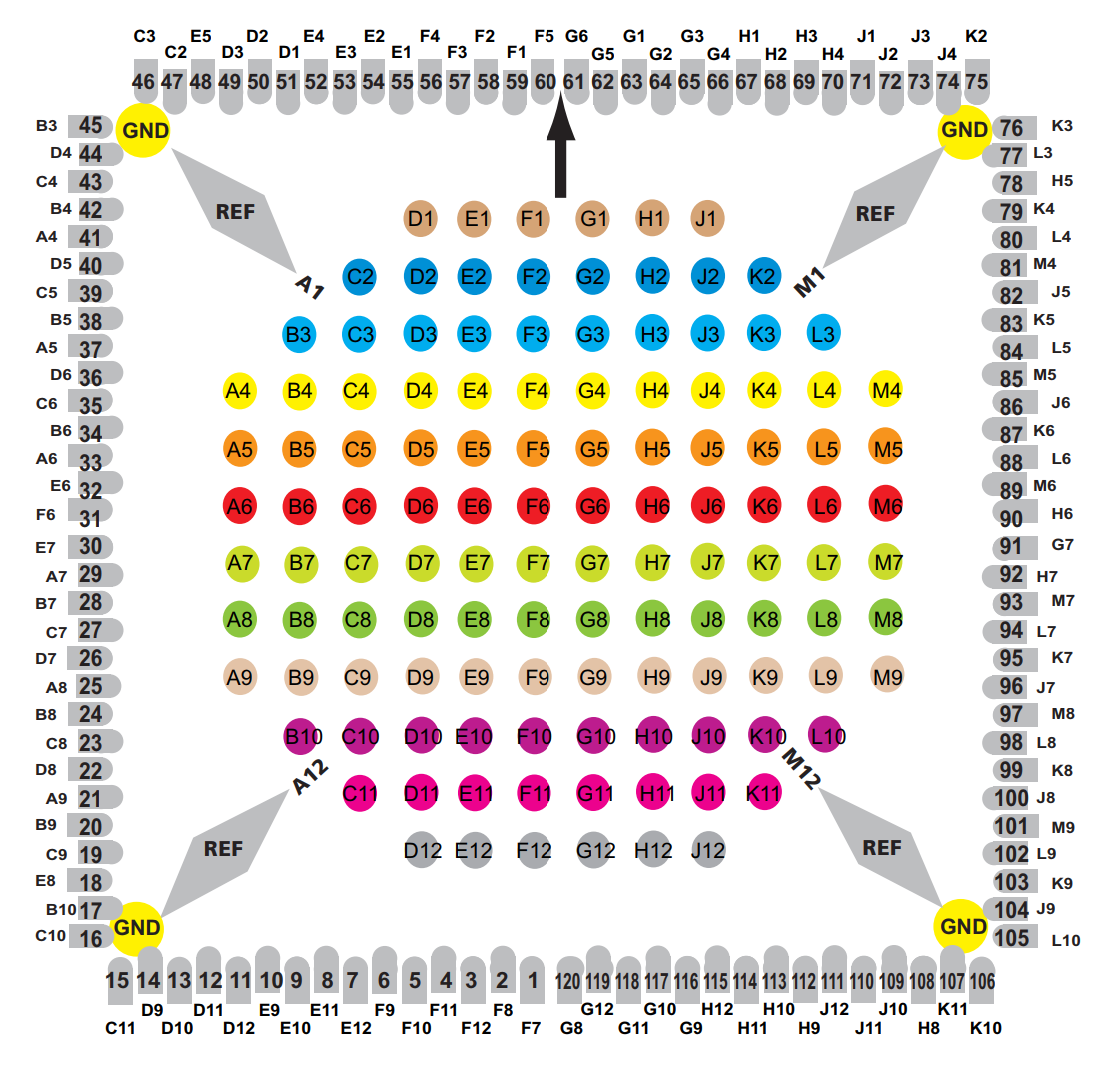

### So we are creating a 12*12 2d matching array (ids)
in light yellow are the cells which exist only in the array
<table border="1">
  <tr>
    <td style="background-color: lightyellow;">A1</td>
    <td style="background-color: lightyellow;">B1</td>
    <td style="background-color: lightyellow;">C1</td>
    <td>D1</td>
    <td>E1</td>
    <td>F1</td>
    <td>G1</td>
    <td>H1</td>
    <td>J1</td>
    <td style="background-color: lightyellow;">K1</td>
    <td style="background-color: lightyellow;">L1</td>
    <td style="background-color: lightyellow;">M1</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A2</td>
    <td style="background-color: lightyellow;">B2</td>
    <td>C2</td>
    <td>D2</td>
    <td>E2</td>
    <td>F2</td>
    <td>G2</td>
    <td>H2</td>
    <td>J2</td>
    <td>K2</td>
    <td style="background-color: lightyellow;">L2</td>
    <td style="background-color: lightyellow;">M2</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A3</td>
    <td>B3</td>
    <td>C3</td>
    <td>D3</td>
    <td>E3</td>
    <td>F3</td>
    <td>G3</td>
    <td>H3</td>
    <td>J3</td>
    <td>K3</td>
    <td>L3</td>
    <td style="background-color: lightyellow;">M3</td>
  </tr>
  <tr>
    <td>A4</td>
    <td>B4</td>
    <td>C4</td>
    <td>D4</td>
    <td>E4</td>
    <td>F4</td>
    <td>G4</td>
    <td>H4</td>
    <td>J4</td>
    <td>K4</td>
    <td>L4</td>
    <td>M4</td>
  </tr>
  <tr>
    <td>A5</td>
    <td>B5</td>
    <td>C5</td>
    <td>D5</td>
    <td>E5</td>
    <td>F5</td>
    <td>G5</td>
    <td>H5</td>
    <td>J5</td>
    <td>K5</td>
    <td>L5</td>
    <td>M5</td>
  </tr>
  <tr>
    <td>A6</td>
    <td>B6</td>
    <td>C6</td>
    <td>D6</td>
    <td>E6</td>
    <td>F6</td>
    <td>G6</td>
    <td>H6</td>
    <td>J6</td>
    <td>K6</td>
    <td>L6</td>
    <td>M6</td>
  </tr>
  <tr>
    <td>A7</td>
    <td>B7</td>
    <td>C7</td>
    <td>D7</td>
    <td>E7</td>
    <td>F7</td>
    <td>G7</td>
    <td>H7</td>
    <td>J7</td>
    <td>K7</td>
    <td>L7</td>
    <td>M7</td>
  </tr>
  <tr>
    <td>A8</td>
    <td>B8</td>
    <td>C8</td>
    <td>D8</td>
    <td>E8</td>
    <td>F8</td>
    <td>G8</td>
    <td>H8</td>
    <td>J8</td>
    <td>K8</td>
    <td>L8</td>
    <td>M8</td>
  </tr>
  <tr>
    <td>A9</td>
    <td>B9</td>
    <td>C9</td>
    <td>D9</td>
    <td>E9</td>
    <td>F9</td>
    <td>G9</td>
    <td>H9</td>
    <td>J9</td>
    <td>K9</td>
    <td>L9</td>
    <td>M9</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A10</td>
    <td>B10</td>
    <td>C10</td>
    <td>D10</td>
    <td>E10</td>
    <td>F10</td>
    <td>G10</td>
    <td>H10</td>
    <td>J10</td>
    <td>K10</td>
    <td>L10</td>
    <td style="background-color: lightyellow;">M10</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A11</td>
    <td style="background-color: lightyellow;">B11</td>
    <td>C11</td>
    <td>D11</td>
    <td>E11</td>
    <td>F11</td>
    <td>G11</td>
    <td>H11</td>
    <td>J11</td>
    <td>K11</td>
    <td style="background-color: lightyellow;">L11</td>
    <td style="background-color: lightyellow;">M11</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A12</td>
    <td style="background-color: lightyellow;">B12</td>
    <td style="background-color: lightyellow;">C12</td>
    <td>D12</td>
    <td>E12</td>
    <td>F12</td>
    <td>G12</td>
    <td>H12</td>
    <td>J12</td>
    <td style="background-color: lightyellow;">K12</td>
    <td style="background-color: lightyellow;">L12</td>
    <td style="background-color: lightyellow;">M12</td>
  </tr>
</table>




In [5]:
def clean_noise(channel_data, sampling_frequency):
    # Calculate the threshold
    threshold = np.median(np.abs(channel_data) / 0.6745) * 5

    # Calculate the number of samples corresponding to 1 millisecond
    npulse = int(1e-3 * sampling_frequency)
    window = npulse * 3  # 3 millisecond window

    # Find positive peaks above the threshold
    positive_peaks, positive_properties = find_peaks(channel_data, height=threshold, distance=1)

    # Find negative peaks below the negative threshold (equivalent to -threshold)
    negative_peaks, negative_properties = find_peaks(-channel_data, height=threshold, distance=1)

    # Combine both sets of peaks and their heights
    all_peaks = np.concatenate((positive_peaks, negative_peaks))
    all_heights = np.concatenate((positive_properties['peak_heights'], negative_properties['peak_heights']))

    # Sort peaks by position
    sorted_indices = np.argsort(all_peaks)
    all_peaks = all_peaks[sorted_indices]
    all_heights = all_heights[sorted_indices]

    # Initialize list to store filtered peaks
    filtered_peaks = []

    # Compare each peak with its neighbors within the 3 ms window
    i = 0
    while i < len(all_peaks):
        # Initialize a new peak group
        peak_group = [all_peaks[i]]
        height_group = [all_heights[i]]
        
        # Initialize j to i in case the inner loop is not executed
        j = i  

        # Check peaks in the next 3 ms window (75 samples)
        for j in range(i + 1, len(all_peaks)):
            if all_peaks[j] - all_peaks[i] > window:
                break
            peak_group.append(all_peaks[j])
            height_group.append(all_heights[j])

        # Retain the peak with the maximum absolute value within the group
        best_peak_index = np.argmax(np.abs(height_group))
        best_peak = peak_group[best_peak_index]
        filtered_peaks.append(best_peak)

        # Now, move the window based on the best peak
        i = j  # Move 'i' to the next peak outside the current window

        # Skip peaks within 75 samples of the best peak
        while i < len(all_peaks) and all_peaks[i] - best_peak <= window:
            i += 1

    # Create a mask to retain samples 0.6 ms before and 1.4 ms after each filtered peak
    mask = np.zeros_like(channel_data, dtype=bool)
    for peak in filtered_peaks:
        start = int(max(0, peak - (0.6 * npulse)))  # 0.6 ms before the peak
        end = int(min(len(channel_data), peak + (1.4 * npulse)))  # 1.4 ms after the peak
        mask[start:end + 1] = True

    # Apply the mask to the data
    return np.where(mask, channel_data, 0), filtered_peaks

In [6]:
def transform_data_to_3d_array(file_name, folder_path = r'npy_files'):
    channel_raw_data = McsPy.McsData.RawData(file_name)
    recording = channel_raw_data.recordings[0]
    try:  # Try to get the analog stream, most of the time it will be the in place 3 but sometimes it will be 0
        analog_stream = recording.analog_streams[3]
    except KeyError:
        try:
            analog_stream = recording.analog_streams[0]
        except KeyError:
            print("Error: No analog stream found in the file " + file_name + " Skipping...")
            return
#     start_time = time.time()
    samples = analog_stream.channel_data.shape[1]
    array_3d = np.zeros((12, 12, samples), dtype=float)
    ids = np.empty((12, 12), dtype=object)

    for i in range(12):
        for j in range(12):
            # Convert number to uppercase character (A-H) or 'J' for index 8
            ids[i, j] = chr(j + 65) + str(i + 1) if j < 8 else chr(j + 66) + str(i + 1)

    # Create a boolean mask to check if IDs are in channels_dict.values()
    mask = np.isin(ids, list(channels_dict.values()))

    # Get the indices where the mask is True
    indices = np.where(mask)

    count = 0
#     Get samples from analog_stream for the indices where mask is True, 1e6 is to convert from V to uV
    for idx, (i, j) in enumerate(zip(*indices)):
        channel_data = analog_stream.get_channel(get_ch_from_id(ids[i, j]))[0] * 1e6
        # clean noise
        sampling_frequency = round(analog_stream.channel_infos[0].sampling_frequency.magnitude)  # Hz
        channel_data, _ = clean_noise(channel_data, sampling_frequency)
        array_3d[i, j] = channel_data
        count += 1
        if count % 10 == 0:
            print(f"Processed {count} channels out of {len(indices[0])}")

    sampling_frequency = int(sampling_frequency / 1000)  # kHz
    # Save the 3D array to a file in the npy_files folder
    if folder_path == r'npy_files':
        if 'control' in file_name or 'w_oMNPs' in file_name or 'woMNPs' in file_name:
            folder_path = fr'npy_files\w_oMNPs'
            if sampling_frequency == 10: # we want to put them on the side because there are just a few so they won't be part of the training
                folder_path = fr'npy_files\{sampling_frequency}_w_oMNPs'                
        if 'withMNPs' in file_name:
            folder_path = fr'npy_files\withMNPs'
            if sampling_frequency == 10:
                folder_path = fr'npy_files\{sampling_frequency}_withMNPs'
    file_name = file_name.split('/')[-1].split('.')[0]
    cleaned_name = file_name[file_name.find('\\') + 1:]
    cleaned_name = cleaned_name.replace('\\', '.')
    fn = os.path.join(folder_path, "data_" + cleaned_name + ".npy")
    np.save(fn, array_3d)
    print(f"saving file {cleaned_name} to {folder_path}")

#     end_time = time.time()
#     print(f"Time taken: {end_time - start_time} seconds, saved to {fn}")


In [7]:
def plot_channel(channel_number, x_axis='sample', from_sample=0, to_sample=1000, clean=False, mark=False):
    sampling_frequency = round(analog_stream.channel_infos[0].sampling_frequency.magnitude)  # Hz
    channel_data = analog_stream.get_channel(channel_number)[0]  # get the data by get channel function
    plt.figure(figsize=(10, 6))
    channel_id = channels_dict[channel_number + 1]
    # amplitude is in volts, we want to display it in micro volts
    channel_data = channel_data * 1e6

    if clean:  # if we want to clean the noise like in the "transform_data_to_3d_array" function
        # clean noise and get filtered peaks
        channel_data, filtered_peaks = clean_noise(channel_data, sampling_frequency)
    else:
        # Calculate the default threshold without cleaning
        _, filtered_peaks = clean_noise(channel_data, sampling_frequency)
    if mark:
        # Filter peaks to include only those within the specified range
        filtered_peaks = np.array([peak for peak in filtered_peaks if from_sample <= peak < to_sample])
        # Adjust the peak indices to be relative to the sliced data
        filtered_peaks_relative = (filtered_peaks - from_sample).astype(int)

    # slice the data to display only a part of it
    channel_data = channel_data[from_sample:to_sample]
    if x_axis == 'time':
        time = [i / sampling_frequency + from_sample / sampling_frequency for i in range(len(channel_data))]
        plt.plot(time, channel_data, label=f'Channel {channel_id}')
        plt.xlabel('Time (s)')
        if mark: # Mark peaks on the plot
            # Convert peaks to time
            peak_times = filtered_peaks / sampling_frequency
            plt.plot(np.array(peak_times), channel_data[filtered_peaks_relative], 'o', label='Peaks')
    else:
        sample_indices = np.arange(from_sample, to_sample)
        plt.plot(sample_indices, channel_data, label=f'Channel {channel_id}')
        plt.xlabel('Sample Index')
        if mark: # Mark peaks on the plot
            plt.plot(filtered_peaks, channel_data[filtered_peaks_relative], 'o', label='Peaks')
    plt.title(f'Plot of Channel {channel_id}')
    plt.ylabel('Amplitude [µV]')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def plot_two_channels(channel_number1, channel_number2, x_axis='sample', from_sample=0, to_sample=1000, clean=False, mark=False):
    sampling_frequency = round(analog_stream.channel_infos[0].sampling_frequency.magnitude)  # Hz
    channel_data1 = analog_stream.get_channel(channel_number1)[0]
    channel_data2 = analog_stream.get_channel(channel_number2)[0]

    channel_id1 = channels_dict[channel_number1 + 1]
    channel_id2 = channels_dict[channel_number2 + 1]
    # amplitude is in volts, we want to display it in micro volts
    channel_data1 = channel_data1 * 1e6
    channel_data2 = channel_data2 * 1e6

    if clean:  # if we want to clean the noise like in the "transform_data_to_3d_array" function
        channel_data1, filtered_peaks1 = clean_noise(channel_data1, sampling_frequency)
        channel_data2, filtered_peaks2 = clean_noise(channel_data2, sampling_frequency)
    else:
        # Calculate the default threshold without cleaning
        _, filtered_peaks1 = clean_noise(channel_data1, sampling_frequency)    
        _, filtered_peaks2 = clean_noise(channel_data2, sampling_frequency)
    if mark:
        # Filter peaks to include only those within the specified range
        filtered_peaks1 = np.array([peak for peak in filtered_peaks1 if from_sample <= peak < to_sample])
        filtered_peaks2 = np.array([peak for peak in filtered_peaks2 if from_sample <= peak < to_sample])
        # Adjust the peak indices to be relative to the sliced data
        filtered_peaks_relative1 = (filtered_peaks1 - from_sample).astype(int)
        filtered_peaks_relative2 = (filtered_peaks2 - from_sample).astype(int)

    # slice the data to display only a part of it
    channel_data1 = channel_data1[from_sample:to_sample]
    channel_data2 = channel_data2[from_sample:to_sample]

    plt.figure(figsize=(10, 6))
    if x_axis == 'time':
        time = [i / sampling_frequency + from_sample / sampling_frequency for i in range(len(channel_data1))]
        plt.plot(time, channel_data1, label=f'Channel {channel_id1}')
        plt.plot(time, channel_data2, label=f'Channel {channel_id2}')
        plt.xlabel('Time (s)')
        if mark: # Mark peaks on the plot
            # Convert peaks to time
            peak_times1 = filtered_peaks1 / sampling_frequency
            peak_times2 = filtered_peaks2 / sampling_frequency
            plt.plot(np.array(peak_times1), channel_data1[filtered_peaks_relative1], 'o', label='Peaks channel 1')
            plt.plot(np.array(peak_times2), channel_data2[filtered_peaks_relative2], 'o', label='Peaks channel 2')
    else:
        sample_indices = np.arange(from_sample, to_sample)
        plt.plot(sample_indices, channel_data1, label=f'Channel {channel_id1}')
        plt.plot(sample_indices, channel_data2, label=f'Channel {channel_id2}')
        plt.xlabel('Sample Index')
        if mark: # Mark peaks on the plot
            plt.plot(filtered_peaks1, channel_data1[filtered_peaks_relative1], 'o', label='Peaks channel 1')
            plt.plot(filtered_peaks2, channel_data2[filtered_peaks_relative2], 'o', label='Peaks channel 2')
    plt.title(f'Plot of Channel {channel_id1} and Channel {channel_id2}')
    plt.ylabel('Amplitude [µV]')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
channels_dict = {120: "G8", 119: "G12", 118: "G11", 117: "G10", 116: "G9", 115: "H12", 114: "H11", 113: "H10",
                 112: "H9", 111: "J12", 110: "J11", 109: "J10", 108: "H8", 107: "K11", 106: "K10", 105: "L10",
                 104: "J9", 103: "K9", 102: "L9", 101: "M9", 100: "J8", 99: "K8", 98: "L8", 97: "M8", 96: "J7",
                 95: "K7", 94: "L7", 93: "M7", 92: "H7", 91: "G7", 90: "H6", 89: "M6", 88: "L6", 87: "K6", 86: "J6",
                 85: "M5", 84: "L5", 83: "K5", 82: "J5", 81: "M4", 80: "L4", 79: "K4", 78: "H5", 77: "L3", 76: "K3",
                 75: "K2", 74: "J4", 73: "J3", 72: "J2", 71: "J1", 70: "H4", 69: "H3", 68: "H2", 67: "H1", 66: "G4",
                 65: "G3", 64: "G2", 63: "G1", 62: "G5", 61: "G6", 60: "F5", 59: "F1", 58: "F2", 57: "F3", 56: "F4",
                 55: "E1", 54: "E2", 53: "E3", 52: "E4", 51: "D1", 50: "D2", 49: "D3", 48: "E5", 47: "C2", 46: "C3",
                 45: "B3", 44: "D4", 43: "C4", 42: "B4", 41: "A4", 40: "D5", 39: "C5", 38: "B5", 37: "A5", 36: "D6",
                 35: "C6", 34: "B6", 33: "A6", 32: "E6", 31: "F6", 30: "E7", 29: "A7", 28: "B7", 27: "C7", 26: "D7",
                 25: "A8", 24: "B8", 23: "C8", 22: "D8", 21: "A9", 20: "B9", 19: "C9", 18: "E8", 17: "B10", 16: "C10",
                 15: "C11", 14: "D9", 13: "D10", 12: "D11", 11: "D12", 10: "E9", 9: "E10", 8: "E11", 7: "E12", 6: "F9",
                 5: "F10", 4: "F11", 3: "F12", 2: "F8", 1: "F7"}

## Plots examples

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">


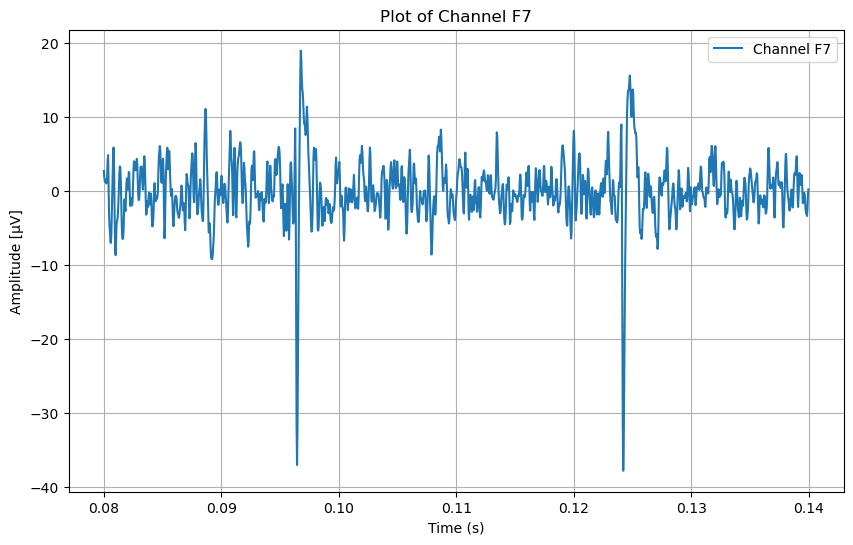

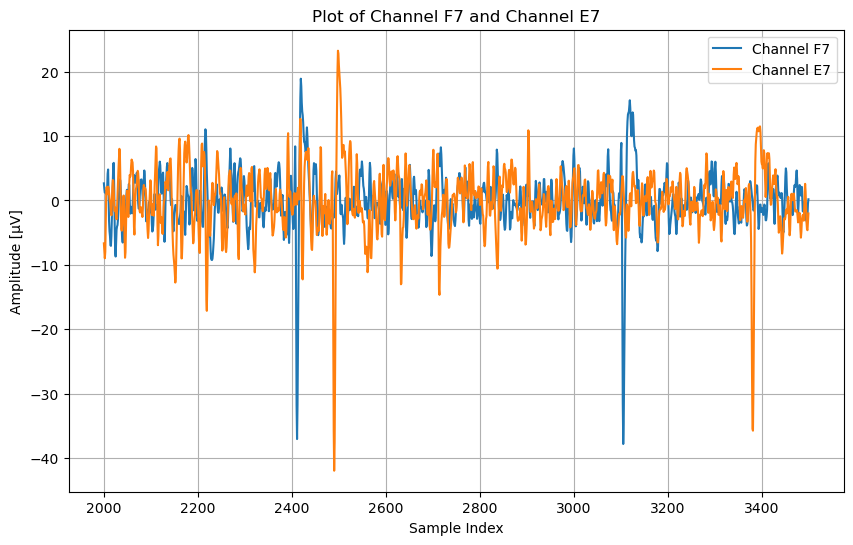

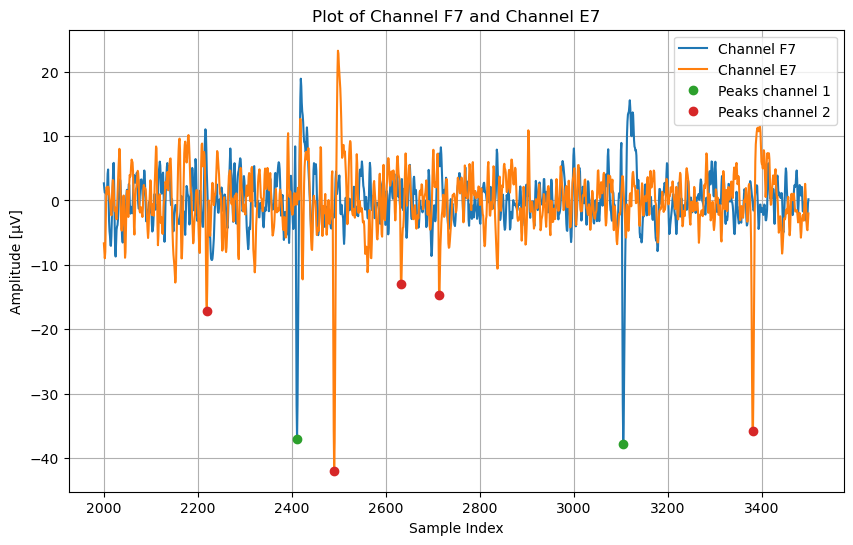

In [10]:
# Examples of different plots
channel_raw_data = McsPy.McsData.RawData('m.h5')
analog_stream = channel_raw_data.recordings[0].analog_streams[0]

plot_channel(0, 'time', from_sample=2000, to_sample=3500)  # plot channel 0 with time on x axis
plot_two_channels(0, 29, 'sample', from_sample=2000, to_sample=3500)  # plot channel 0 and 1 with sample index on x axis

# with marking of the peaks
plot_two_channels(0, 29, 'sample', from_sample=2000, to_sample=3500, mark=True) 

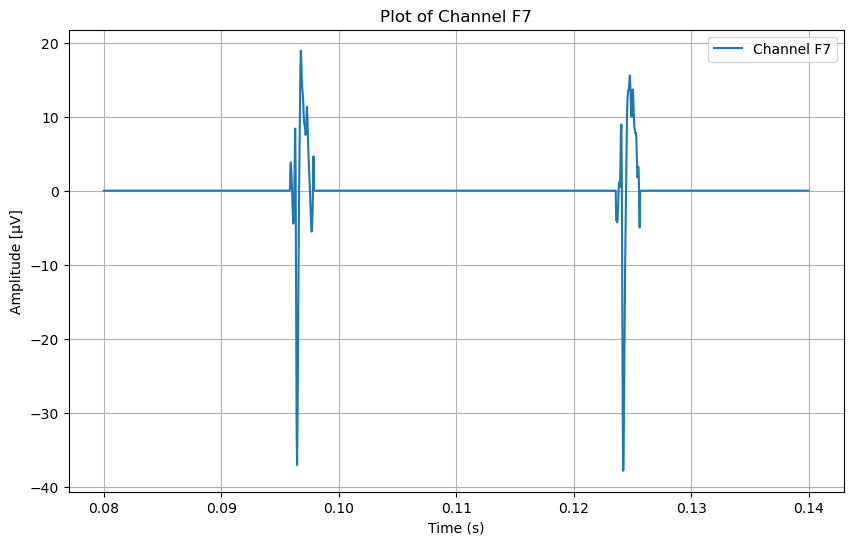

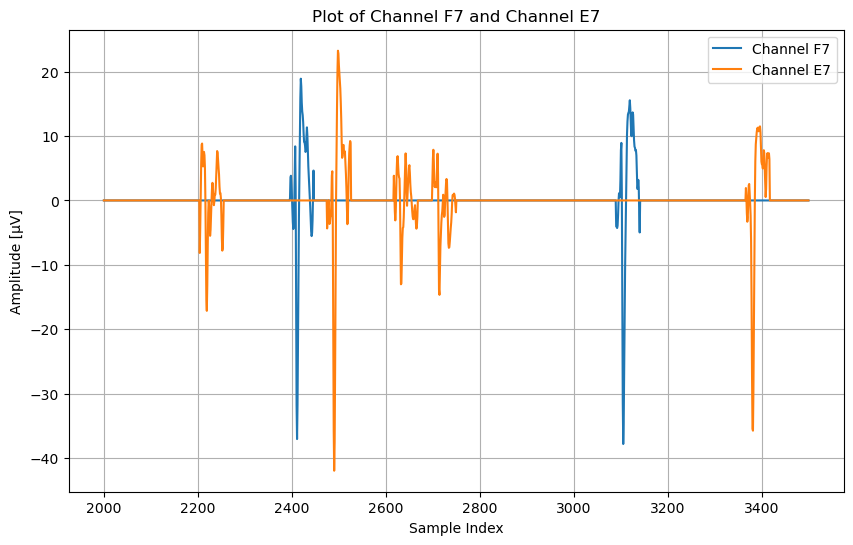

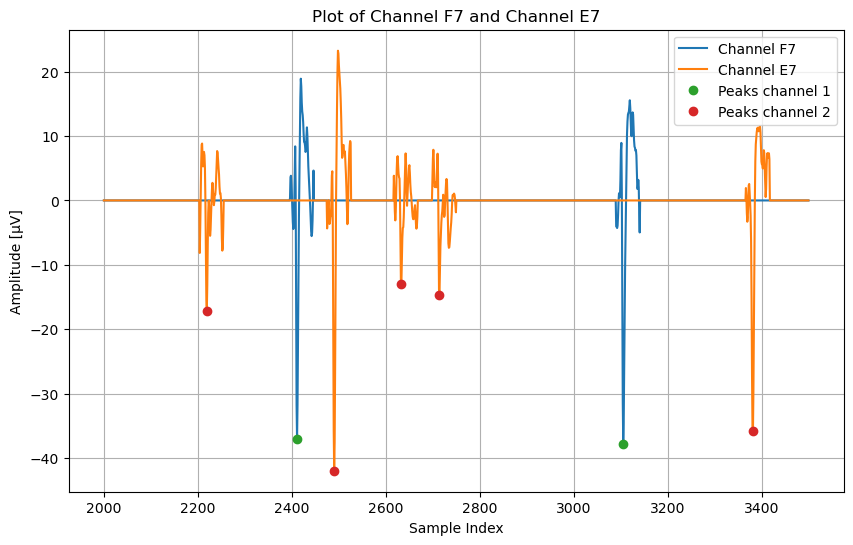

In [11]:
# Plots after cleaning the noise
plot_channel(0, 'time', from_sample=2000, to_sample=3500, clean=True, mark=False)  # plot channel 0 with time on x axis
plot_two_channels(0, 29, 'sample', from_sample=2000, to_sample=3500, clean=True, mark=False)  # plot channel 0 and 29 with sample index on x axis
plot_two_channels(0, 29, 'sample', from_sample=2000, to_sample=3500, clean=True, mark=True)  # plot channel 0 and 29 with sample index on x axis


## Extract data

step 1 - extract the h5 files from all zip files to the MEA recordings folder

In [12]:
# extract_zip_files()  # extract the zip files to the folder MEA recordings as h5 files

step 2 - extract the data from all the h5 files to 3D numpy arrays

In [13]:
# extract_data_from_all_files()  # extract the data from all the h5 files to the npy_files folder as 3D npy arrays 

# Data Preparation and Custom Dataset Class

In this section, we define a custom dataset class to handle 3D data chunks and load file paths.


In [14]:
# Custom dataset class for handling 3D data chunks
class Custom3DDataset(Dataset):
    def __init__(self, files, chunk_size=(12, 12, 30000), transform=None):
        """
        Initializes the dataset with a list of files and prepares chunks.

        Args:
            files (list): List of tuples containing file paths and labels.
            chunk_size (tuple): The desired size of each chunk.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.files = files
        self.chunk_size = chunk_size
        self.transform = transform
        self.chunk_indices = []
        self.prepare_chunks()

    def prepare_chunks(self):
        """
        Prepares chunk indices for each file based on the chunk size.
        """
        for file_idx, (file_path, label) in enumerate(self.files):
            sample = np.load(file_path)
            total_depth = sample.shape[2]
            num_chunks = total_depth // self.chunk_size[2]
            for i in range(num_chunks):
                self.chunk_indices.append((file_idx, i))

    def __len__(self):
        return len(self.chunk_indices)

    def __getitem__(self, idx):
        """
        Retrieves a specific chunk based on the index.

        Args:
            idx (int): Index of the chunk to retrieve.

        Returns:
            tuple: (sample_chunk, label) where sample_chunk is the data tensor and label is its class.
        """
        file_idx, chunk_idx = self.chunk_indices[idx]
        file_path, label = self.files[file_idx]
        sample = np.load(file_path)
        
        start_idx = chunk_idx * self.chunk_size[2]
        end_idx = start_idx + self.chunk_size[2]
        sample_chunk = sample[:, :, start_idx:end_idx]
        
        if self.transform:
            sample_chunk = self.transform(sample_chunk)
        
        # Add channel dimension
        sample_chunk = sample_chunk[np.newaxis, :]  
        sample_chunk = torch.tensor(sample_chunk, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        return sample_chunk, label

# Padding or Truncating Tensors

Next, we define a function to pad or truncate tensors to a target shape and a custom collate function for the DataLoader.


In [15]:
def pad_or_truncate(tensor, target_shape):
    """
    Pads or truncates a tensor to match the target shape.

    Args:
        tensor (torch.Tensor): The tensor to pad or truncate.
        target_shape (tuple): The desired shape.

    Returns:
        torch.Tensor: The tensor after padding or truncating.
    """
    padded = torch.zeros(target_shape)
    min_shape = [min(s, t) for s, t in zip(tensor.shape, target_shape)]
    slices = tuple(slice(0, s) for s in min_shape)
    padded[slices] = tensor[slices]
    return padded


def custom_collate_fn(batch, target_shape):
    """
    Custom collate function to handle batching of samples with varying shapes.

    Args:
        batch (list): List of tuples (sample, label).
        target_shape (tuple): The desired shape for all samples in the batch.

    Returns:
        tuple: Batch of samples and labels.
    """
    samples = [pad_or_truncate(sample, target_shape) for sample, _ in batch]
    labels = [label for _, label in batch]
    samples = torch.stack(samples)
    labels = torch.tensor(labels)
    return samples, labels

# Loading Dataset and Splitting into Train/Validation Sets

We will now load the dataset, split it into training and validation sets, and create DataLoaders.

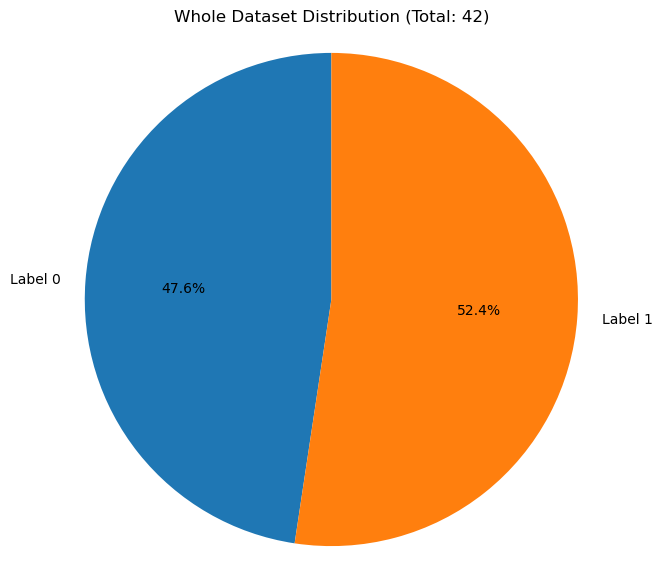

Total training files: 33
Training - Label 0: 16, Label 1: 17
Train Files:
./npy_files\w_oMNPs\data_2023-09-26T13-46-50McsRecording_MEA22768_control_2minC_A-00020.npy
./npy_files\withMNPs\data_2023-09-26T15-13-04McsRecording_MEA22770_withMNPs_2minB_A-00020.npy
./npy_files\w_oMNPs\data_2023-09-26T13-27-18McsRecording_MEA21009_control_2minD_A-00020.npy
./npy_files\w_oMNPs\data_2023-09-26T14-01-59McsRecording_MEA20491_control_2minB_A-00020.npy
./npy_files\withMNPs\data_2023-09-26T14-51-25McsRecording_MEA20490_withMNPs_2minC_A-00020.npy
./npy_files\withMNPs\data_2023-09-26T14-30-34McsRecording_MEA21010_withMNPs_2minE_A-00020.npy
./npy_files\w_oMNPs\data_2023-09-26T13-49-12McsRecording_MEA22768_control_2minD_A-00020.npy
./npy_files\w_oMNPs\data_2023-09-26T13-15-38McsRecording_MEA21009_control_2minA_A-00020.npy
./npy_files\withMNPs\data_2023-08-06T13-59-03McsRecording_21010MEA_withMNPs_A-00020.npy
./npy_files\w_oMNPs\data_2023-09-26T13-29-38McsRecording_MEA21009_control_2minE_A-00020.npy
./np

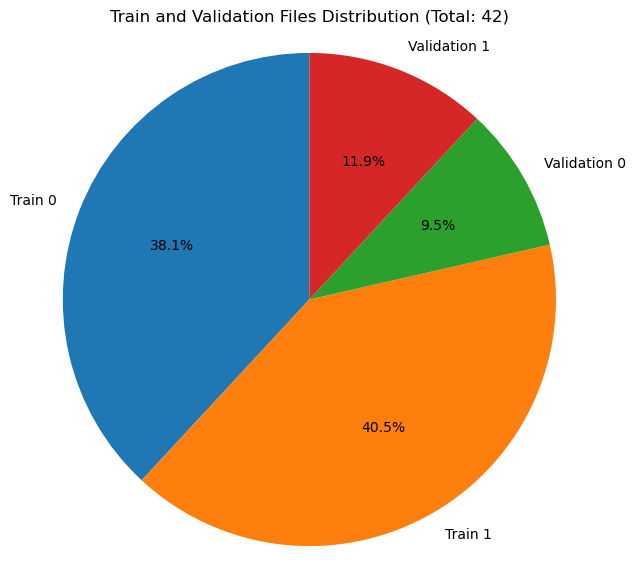

Training Dataset:
  Total Chunks: 3389
  Label 0 Chunks: 1691
  Label 1 Chunks: 1698
  Iterations per Epoch: 847
Validation Dataset:
  Total Chunks: 900
  Label 0 Chunks: 400
  Label 1 Chunks: 500
  Iterations per Epoch: 225


In [16]:
# Main execution

# Function to create a pie chart for a given dataset
def create_pie_chart(sizes, labels, title, colors=['#ff9999','#66b3ff']):
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

data_dir = './npy_files'  # Update this path to your data directory
chunk_size = (12, 12, 30000)

# Load all file paths and labels
w_oMNPs_dir = os.path.join(data_dir, 'w_oMNPs')
withMNPs_dir = os.path.join(data_dir, 'withMNPs')

files = []
# Load w_oMNPs files (label 0)
for filename in os.listdir(w_oMNPs_dir):
    if filename.endswith('.npy'):
        file_path = os.path.join(w_oMNPs_dir, filename)
        files.append((file_path, 0))

# Load withMNPs files (label 1)
for filename in os.listdir(withMNPs_dir):
    if filename.endswith('.npy'):
        file_path = os.path.join(withMNPs_dir, filename)
        files.append((file_path, 1))

# Extract labels for stratification
labels = [label for _, label in files]

# Perform stratified train-validation split on files
train_files, val_files = train_test_split(
    files,
    test_size=0.2,
    random_state=42,
    stratify=labels, 
    shuffle=True
)

# Pie Chart for the whole dataset
whole_dataset_labels = [label for _, label in files]
whole_dataset_counts = Counter(whole_dataset_labels)
whole_dataset_sizes = [whole_dataset_counts[0], whole_dataset_counts[1]]
create_pie_chart(whole_dataset_sizes, ['Label 0', 'Label 1'], f"Whole Dataset Distribution (Total: {len(files)})")

# Print statistics for training files
train_labels = [label for _, label in train_files]
train_label_counts = Counter(train_labels)
print(f"Total training files: {len(train_files)}")
print(f"Training - Label 0: {train_label_counts[0]}, Label 1: {train_label_counts[1]}")

# print train files names
print("Train Files:")
for file in train_files:
    print(file[0])

# Print statistics for validation files
val_labels = [label for _, label in val_files]
val_label_counts = Counter(val_labels)
print(f"Total validation files: {len(val_files)}")
print(f"Validation - Label 0: {val_label_counts[0]}, Label 1: {val_label_counts[1]}")

# print validation files names
print("Validation Files:")
for file in val_files:
    print(file[0])

# Create Pie Chart training and validation
sizes = [train_label_counts[0], train_label_counts[1], val_label_counts[0], val_label_counts[1]]
create_pie_chart(
    sizes, ['Train 0', 'Train 1', 'Validation 0', 'Validation 1'], f"Train and Validation Files Distribution (Total: {len(val_files) + len(train_files)})")


# Initialize datasets
train_dataset = Custom3DDataset(train_files, chunk_size=chunk_size)
val_dataset = Custom3DDataset(val_files, chunk_size=chunk_size)

# Define target shape for padding/truncating
target_shape = (1, 12, 12, 30000)  # Adjust this to the desired size

# Create DataLoaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: custom_collate_fn(x, target_shape)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: custom_collate_fn(x, target_shape)
)

# Print dataset statistics
def print_dataset_stats(dataset, name):
    label_counts = Counter(
        dataset.files[file_idx][1]
        for file_idx, _ in dataset.chunk_indices
    )
    total_chunks = len(dataset)
    print(f"{name} Dataset:")
    print(f"  Total Chunks: {total_chunks}")
    print(f"  Label 0 Chunks: {label_counts[0]}")
    print(f"  Label 1 Chunks: {label_counts[1]}")
    print(f"  Iterations per Epoch: {len(dataset) // 4}")  # Assuming batch_size=4

print_dataset_stats(train_dataset, "Training")
print_dataset_stats(val_dataset, "Validation")

# Defining the CNN-LSTM Model

Here, we define a CNN-LSTM model for processing the 3D data chunks.

In [21]:
# Define the model
class CNNLSTMModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTMModel, self).__init__()

        # 3D convolutional layers to extract spatial features from 3D input data.
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Max pooling layer to reduce spatial dimensions and retain important features.
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        # LSTM layer to capture temporal dependencies in the data.
        # input_size is set to 64 because it's the number of channels output by the last conv layer.
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)

##         Dropout layer
#         self.dropout = nn.Dropout(p=0.3)  # Dropout with probability 0.5
        
        # Fully connected layer to map the LSTM outputs to the desired number of output classes.
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1, x.size(1))  # Reshape for LSTM
        x, (hn, cn) = self.lstm(x)
        x = hn[-1]  # Use the last hidden state from LSTM
#         x = self.dropout(x)  # Apply Dropout after LSTM
        x = self.fc(x)
        return x

num_classes = 2
model = CNNLSTMModel(num_classes)

# Hyperparameters
learning_rate = 0.001
num_epochs = 20

print(model)
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


CNNLSTMModel(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
The model has 169250 trainable parameters.


# Model Checkpointing

We will define functions to save and load model checkpoints.


In [22]:
# Function to save model and optimizer state
def save_checkpoint(epoch, model, optimizer, train_losses, val_losses, train_accuracies, val_accuracies, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
    torch.save(checkpoint, filename)

# Function to load model and optimizer state
def load_checkpoint(filename='checkpoint.pth', load_weights_only=False):
    # With weights_only=False (default) The checkpoint will contain all serialized objects, including the model 
    # state dictionary,optimizer state dictionary, epoch, loss values, accuracies, and potentially other custom objects.
    checkpoint = torch.load(filename, weights_only=load_weights_only)  
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    return start_epoch, train_losses, val_losses, train_accuracies, val_accuracies

# Check if there's a checkpoint available
try:
    start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_checkpoint()
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("Starting training from scratch")


Starting training from scratch


# Training and Validation Loop

We define the training and validation loop for the model.


In [23]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to stop training when the loss does not improve after a certain patience.

        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increase counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True  # Stop if patience limit is reached


In [24]:
# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the parameters
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}%')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    # Lists to store true and predicted labels
    y_validation = []
    y_predicted = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation', unit='batch'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Append true and predicted labels for confusion matrix and report
            y_validation.extend(labels.cpu().numpy())
            y_predicted.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}%')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    # Save the model and optimizer state
    save_checkpoint(epoch, model, optimizer, train_losses, val_losses, train_accuracies, val_accuracies)

# Save the number of completed epochs for plotting
completed_epochs = epoch + 1  # Store how many epochs were actually run

Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████████████| 848/848 [8:32:14<00:00, 36.24s/batch]


Epoch 1/20, Loss: 0.6947, Accuracy: 49.3361%


Validation: 100%|████████████████| 225/225 [38:35<00:00, 10.29s/batch]


Validation Loss: 0.6949, Accuracy: 44.4444%


Epoch 2/20: 100%|██████████████| 848/848 [6:50:58<00:00, 29.08s/batch]


Epoch 2/20, Loss: 0.6943, Accuracy: 48.2443%


Validation: 100%|████████████████| 225/225 [58:42<00:00, 15.65s/batch]


Validation Loss: 0.6926, Accuracy: 55.5556%


Epoch 3/20: 100%|██████████████| 848/848 [7:35:49<00:00, 32.25s/batch]


Epoch 3/20, Loss: 0.6934, Accuracy: 51.2836%


Validation: 100%|████████████████| 225/225 [58:13<00:00, 15.52s/batch]


Validation Loss: 0.6925, Accuracy: 55.5556%


Epoch 4/20: 100%|██████████████| 848/848 [8:00:39<00:00, 34.01s/batch]


Epoch 4/20, Loss: 0.6942, Accuracy: 49.0705%


Validation: 100%|████████████████| 225/225 [59:10<00:00, 15.78s/batch]


Validation Loss: 0.6956, Accuracy: 44.4444%


Epoch 5/20: 100%|██████████████| 848/848 [7:55:25<00:00, 33.64s/batch]


Epoch 5/20, Loss: 0.6939, Accuracy: 49.0115%


Validation: 100%|████████████████| 225/225 [58:31<00:00, 15.61s/batch]


Validation Loss: 0.6939, Accuracy: 44.4444%


Epoch 6/20: 100%|██████████████| 848/848 [7:46:03<00:00, 32.98s/batch]


Epoch 6/20, Loss: 0.6937, Accuracy: 49.0410%


Validation: 100%|██████████████| 225/225 [1:00:15<00:00, 16.07s/batch]


Validation Loss: 0.6926, Accuracy: 55.5556%


Epoch 7/20: 100%|██████████████| 848/848 [8:19:03<00:00, 35.31s/batch]


Epoch 7/20, Loss: 0.6936, Accuracy: 49.8672%


Validation: 100%|██████████████| 225/225 [1:03:14<00:00, 16.86s/batch]

Validation Loss: 0.6975, Accuracy: 44.4444%
Early stopping triggered at epoch 7


# Plotting Training and Validation Metrics

Finally, we will plot the confusion_matrix, classification_report, training and validation loss and accuracy over epochs.


In [25]:
# Convert lists to arrays for evaluation
y_validation = np.array(y_validation)
y_predicted = np.array(y_predicted)

# Print confusion matrix and classification report
print('Confusion matrix on validation set:\n')

# Print the confusion matrix with headers
print(pd.DataFrame(confusion_matrix(y_validation, y_predicted), 
                   index=['Actual 0', 'Actual 1'],columns=['Predicted 0', 'Predicted 1']))

print(f"\nClassification report:\n{classification_report(y_validation, y_predicted)}")

Confusion matrix on validation set:

          Predicted 0  Predicted 1
Actual 0          400            0
Actual 1          500            0

Classification report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62       400
           1       0.00      0.00      0.00       500

    accuracy                           0.44       900
   macro avg       0.22      0.50      0.31       900
weighted avg       0.20      0.44      0.27       900



C:\Users\golan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\golan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\golan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


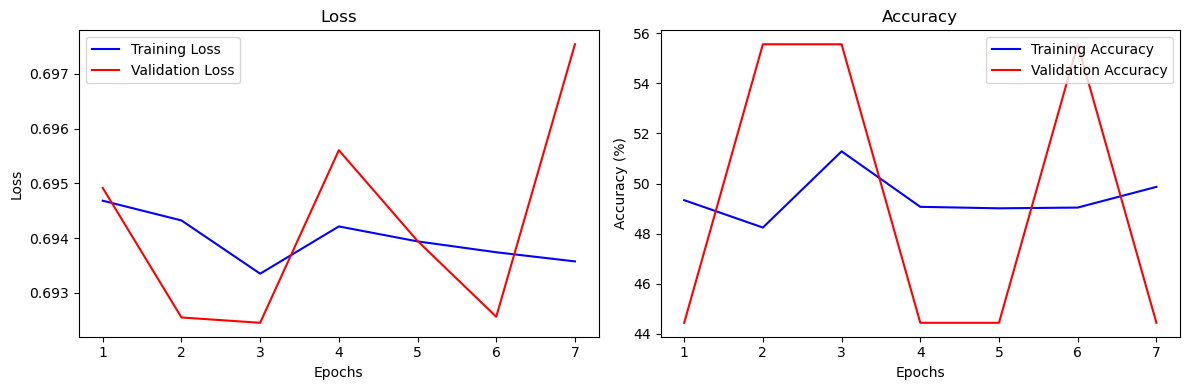

In [26]:
# Plotting training and validation loss/accuracy
epochs = range(1, completed_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs[:len(train_losses)], train_losses, 'b', label='Training Loss')
plt.plot(epochs[:len(val_losses)], val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs[:len(train_accuracies)], train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs[:len(val_accuracies)], val_accuracies, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# Classify a new recodring



In [27]:
# # Step 1 - Extract the zip folder to H5 files
# extract_zip_files(from_folder="./NewData", to_folder="./New_Data/NewRecordings")

In [28]:
# Step 2 - Extract the H5 files to npy arrays
extract_data_from_all_files(from_folder="./NewData/NewRecordings", to_folder=r'./NewData/npy')

found 12 h5 files in ./NewData/NewRecordings


  0%|                                          | 0/12 [00:00<?, ?it/s]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000125), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120
saving file 2023-08-06T11-44-31McsRecording_20490MEA_w_oMNPs_A-00020 to ./NewData/npy


  8%|██▌                            | 1/12 [07:43<1:24:58, 463.47s/it]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120
saving file 2023-08-06T11-48-04McsRecording_20490MEA_w_oMNPs_A-00020 to ./NewData/npy


 17%|█████▏                         | 2/12 [15:17<1:16:17, 457.80s/it]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120


 25%|███████▊                       | 3/12 [22:55<1:08:42, 458.06s/it]

saving file 2023-08-06T11-48-26McsRecording_20490MEA_w_oMNPs_A-00020 to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120


 33%|██████████▎                    | 4/12 [30:37<1:01:16, 459.56s/it]

saving file 2023-08-06T11-48-49McsRecording_20490MEA_w_oMNPs_A-00020 to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 2997500), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120


 42%|█████████████▊                   | 5/12 [38:15<53:32, 458.90s/it]

saving file 2023-08-06T11-50-56McsRecording_20490MEA_w_oMNPs_A-00020 to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000800), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120
saving file 2024-08-14T21-39-382023-11-27T12-14-45MEA21010_withMNPs_2min_A_A-00020 to ./NewData/npy


 50%|████████████████▌                | 6/12 [45:56<45:58, 459.80s/it]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120


 58%|███████████████████▎             | 7/12 [53:37<38:19, 459.95s/it]

saving file 2024-08-14T21-40-232023-11-27T12-14-45MEA21010_withMNPs_2min_B_A-00020 to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120


 67%|████████████████████▋          | 8/12 [1:01:19<30:43, 460.76s/it]

saving file 2024-08-14T21-41-092023-11-27T12-14-45MEA21010_withMNPs_2min_C_A-00020 to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120


 75%|███████████████████████▎       | 9/12 [1:09:05<23:07, 462.47s/it]

saving file 2024-08-14T21-41-332023-11-27T12-14-45MEA21010_withMNPs_2min_D_A-00020 to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 3000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Processed 10 channels out of 120
Processed 20 channels out of 120
Processed 30 channels out of 120
Processed 40 channels out of 120
Processed 50 channels out of 120
Processed 60 channels out of 120
Processed 70 channels out of 120
Processed 80 channels out of 120
Processed 90 channels out of 120
Processed 100 channels out of 120
Processed 110 channels out of 120
Processed 120 channels out of 120
saving file 2024-08-14T21-41-582023-11-27T12-14-45MEA21010_withMNPs_2min_E_A-00020 to ./NewData/npy


 83%|█████████████████████████     | 10/12 [1:16:46<15:24, 462.03s/it]

Recording_0 <HDF5 group "/Data/Recording_0" (3 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 1202000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 1202000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Stream_2 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_2" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 1202000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|V108">
Stream_3 <HDF5 group "/Data/Re

 92%|███████████████████████████▌  | 11/12 [1:20:06<06:21, 381.79s/it]

saving file control to ./NewData/npy
Recording_0 <HDF5 group "/Data/Recording_0" (3 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 1201000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (120, 1201000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (120,), type "|V108">
Stream_2 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_2" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 1201000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|

100%|██████████████████████████████| 12/12 [1:23:31<00:00, 417.66s/it]

saving file withMNPs to ./NewData/npy
Extracted data from 12 h5 files to ./NewData/npy


In [29]:
def classify_new_file(model, file_path, chunk_size=(12, 12, 30000), transform=None, target_shape=(1, 12, 12, 30000)):
    # Load the new file
    sample = np.load(file_path)
    
    # Prepare the chunks
    num_chunks = sample.shape[2] // chunk_size[2]
    predictions = []
    confidences = []

    for i in range(num_chunks):
        start_idx = i * chunk_size[2]
        end_idx = start_idx + chunk_size[2]
        sample_chunk = sample[:, :, start_idx:end_idx]

        if transform:
            sample_chunk = transform(sample_chunk)

        sample_chunk = sample_chunk[np.newaxis, :]  # Add channel dimension
        sample_chunk = torch.tensor(sample_chunk, dtype=torch.float32)

        # Pad or truncate to target shape
        sample_chunk = pad_or_truncate(sample_chunk, target_shape)

        # Add batch dimension
        sample_chunk = sample_chunk.unsqueeze(0)

        # Make prediction
        with torch.no_grad():
            output = model(sample_chunk)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities.data, 1)
            predictions.append(predicted.item())
            confidences.append(confidence.item())

    # Return the majority class prediction and its confidence for the file
    most_common_prediction = Counter(predictions).most_common(1)[0][0]
    # sum of confidences where the prediction is the most common one divided by the total number of chunks
    confidence = sum([conf for pred, conf in zip(predictions, confidences) if pred == most_common_prediction]) / num_chunks
    # ratio of the most common prediction to the total number of chunks
    common_prediction_ratio = Counter(predictions)[most_common_prediction] / num_chunks

    return most_common_prediction, confidence, common_prediction_ratio

In [30]:
# Example usage for new files to classify
new_files = glob.glob(r'./NewData/npy/*.npy')
prediction_dict = {0: 'w_oMNPs', 1: 'withMNPs'}
for file in new_files:
    prediction, confidence, common_prediction_ratio = classify_new_file(model, file)
    print(f'File:{file}')
    print(f'The predicted class for the new file is: {prediction} - {prediction_dict[prediction]}')
    print(f'Confidence of the prediction: {confidence:.4f}')
    print(f'Common prediction ratio: {common_prediction_ratio:.4f}')
    print('--------------')

File:./NewData/npy\data_2023-08-06T11-44-31McsRecording_20490MEA_w_oMNPs_A-00020.npy
The predicted class for the new file is: 0 - w_oMNPs
Confidence of the prediction: 0.5171
Common prediction ratio: 1.0000
--------------
File:./NewData/npy\data_2023-08-06T11-48-04McsRecording_20490MEA_w_oMNPs_A-00020.npy
The predicted class for the new file is: 0 - w_oMNPs
Confidence of the prediction: 0.5171
Common prediction ratio: 1.0000
--------------
File:./NewData/npy\data_2023-08-06T11-48-26McsRecording_20490MEA_w_oMNPs_A-00020.npy
The predicted class for the new file is: 0 - w_oMNPs
Confidence of the prediction: 0.5171
Common prediction ratio: 1.0000
--------------
File:./NewData/npy\data_2023-08-06T11-48-49McsRecording_20490MEA_w_oMNPs_A-00020.npy
The predicted class for the new file is: 0 - w_oMNPs
Confidence of the prediction: 0.5171
Common prediction ratio: 1.0000
--------------
File:./NewData/npy\data_2023-08-06T11-50-56McsRecording_20490MEA_w_oMNPs_A-00020.npy
The predicted class for the